# Линейная регрессия

Данные содержатся в файле `data/lin_reg.txt`. Прочитать их можно следующим так:

In [2]:
import numpy as np
import torch

D = np.loadtxt('data/lin_reg.txt', delimiter=',')
X = D[:, :-1]
y = D[:, -1]

При выполнении заданий **нельзя** пользоваться `scikit-learn` и т.п., только `NumPy`/`JAX`/`TF`/`PyTorch` и `matplotlib`/`seaborn`/`plotly`/etc.

1. Нарисуйте график среднеквадратичной ошибки в зависимости от параметра регуляризации $\alpha$, используя полные данные для обучения и для тестирования. 
2. Подготовьте исходные данные для 5 fold CV.
3. С помощью CV найдите оптимальное значение $\alpha$ на какой-нибудь сетке значений.
4. Постройте валидационную кривую. 
5. Постройте кривую обучения.

In [3]:
import torch

X = torch.tensor(X, dtype=torch.float)
y = torch.tensor(y, dtype=torch.float)

X = torch.hstack((torch.ones(X.shape[0], 1), X))

In [4]:
def mse(y_true, y_pred):
    return (y_true - y_pred).pow(2).mean()


class LinearRegression:
    def __init__(self, learning_rate=0.001, momentum=0.9, loss=mse, C=0.1, epochs=100, batch_size=100):
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.loss = loss
        self.C = C
        self.batch_size=batch_size
        
        self.theta = None
        self.losses = None
        self.prev_grad = 0
        self.epochs = 100
        
    def fit(self, X, y):
        self.theta = torch.rand(X.shape[1], requires_grad=True)
        
        self.losses = []
        iters_number = X.shape[0] // self.batch_size
        
        for epoch in range(self.epochs):
            loss_accuracy = 0
            
            for i in range(iters_number):
                batch_from = i * self.batch_size
                batch_to = (i + 1) * self.batch_size
                
                y_pred = X[batch_from : batch_to] @ self.theta
                loss = self.loss(y[batch_from : batch_to], y_pred)

                loss += self.C * torch.norm(self.theta)
                loss.backward()

                with torch.no_grad():
                    loss_accuracy += loss.item()

                    grad = self.learning_rate * self.theta.grad
                    if self.momentum:
                        grad += self.momentum * self.prev_grad

                    self.theta -= grad
                    self.prev_grad = grad

                    self.theta.grad.zero_()
                        
            self.losses.append(loss_accuracy / iters_number)

    
    def predict(self, X):
        return X @ self.theta

In [6]:
reg = LinearRegression(learning_rate=0.0005, C=0.1, momentum=0.9, batch_size=100)

reg.fit(X, y)

In [7]:
y_pred = reg.predict(X)
mse(y, y_pred)

tensor(94.9867, grad_fn=<MeanBackward0>)

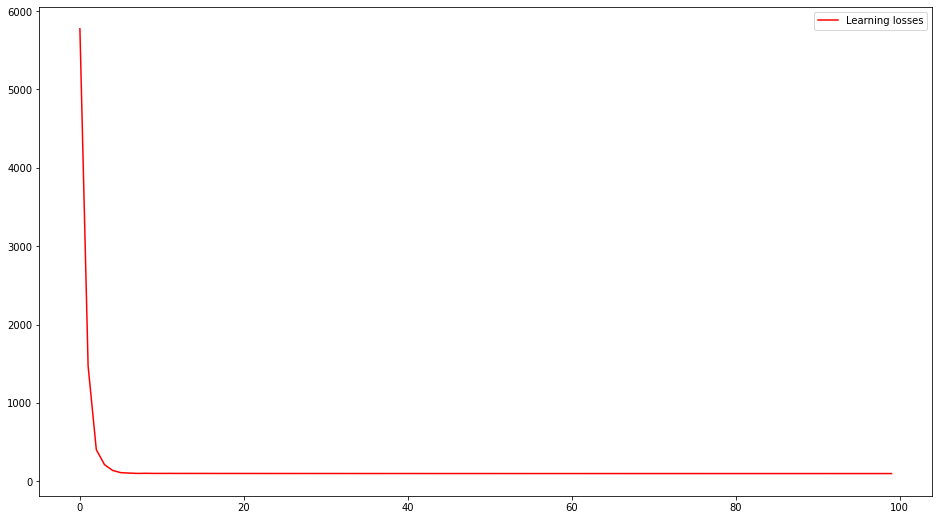

In [8]:
from matplotlib import pyplot as plt


def plot_losses(reg, color="r", label="Learning losses"):
    plt.plot(reg.losses, color, label=label)

plt.figure(figsize=(16, 9))
plot_losses(reg)
plt.legend()
plt.show()

In [9]:
c_losses = []
train_losses = []
cs = np.arange(0.01, 10, 0.3)

for C in cs:
    reg = LinearRegression(C=C)

    reg.fit(X, y)
    
    y_pred = reg.predict(X)
    c_losses.append(mse(y, y_pred))

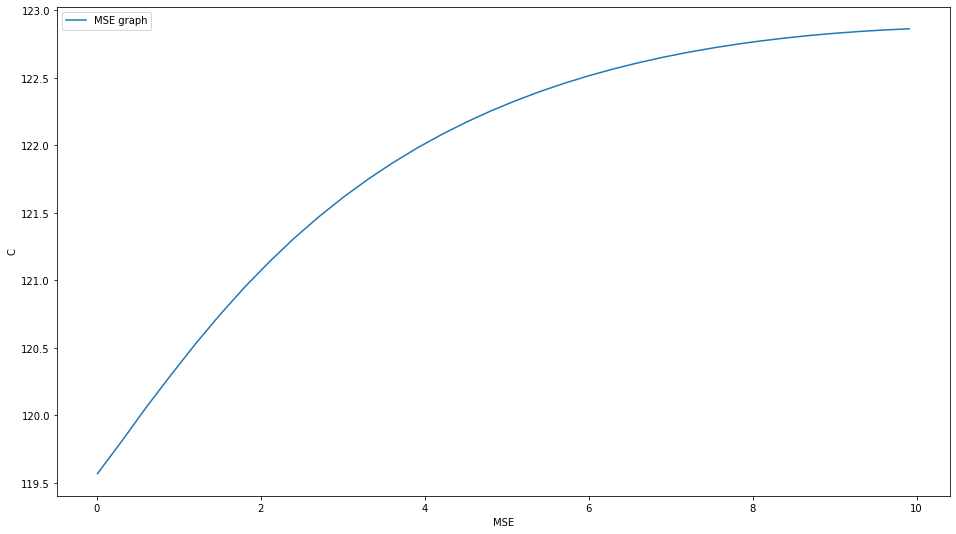

In [10]:
plt.figure(figsize=(16, 9))
plt.plot(cs, c_losses, label="MSE graph")
plt.xlabel("MSE") 
plt.ylabel("C")
plt.legend()
plt.show()

In [11]:
class CrossValidation:
    def __init__(self, items_number, splits_number=5):
        self.items_number = items_number
        self.splits_number = splits_number
    
    def splits(self):
        indicies = np.arange(self.items_number)
        split_size = self.items_number // self.splits_number
        
        for i in range(self.splits_number):
            train_indicies = indicies[0 : i * split_size]
            train_indicies = np.hstack((train_indicies, indicies[(i + 1) * split_size:]))
            
            val_indicies = indicies[i * split_size: (i + 1) * split_size]
            yield (train_indicies, val_indicies)

In [12]:
def get_cross_validation_score(Regressor, X, y, splits_number=5, **params):
    reg = Regressor(**params)
    
    scores = np.zeros( splits_number)
    train_scores = np.zeros( splits_number)
    cv = CrossValidation(X.shape[0])

    for i, (train_indicies, val_indicies) in enumerate(cv.splits()):
        reg.fit(X[train_indicies], y[train_indicies])
        y_pred = reg.predict(X[val_indicies])
        scores[i] = mse(y[val_indicies], y_pred)
        y_pred = reg.predict(X[train_indicies])
        train_scores[i] = mse(y[train_indicies], y_pred)
        
    return scores, train_scores

In [13]:
get_cross_validation_score(LinearRegression, X, y, C=20)

(array([ 89.70316315,  90.63030243, 107.84496307, 108.84643555,
        104.96098328]),
 array([101.8303833 , 101.41610718,  98.44598389,  95.10095978,
         98.17198944]))

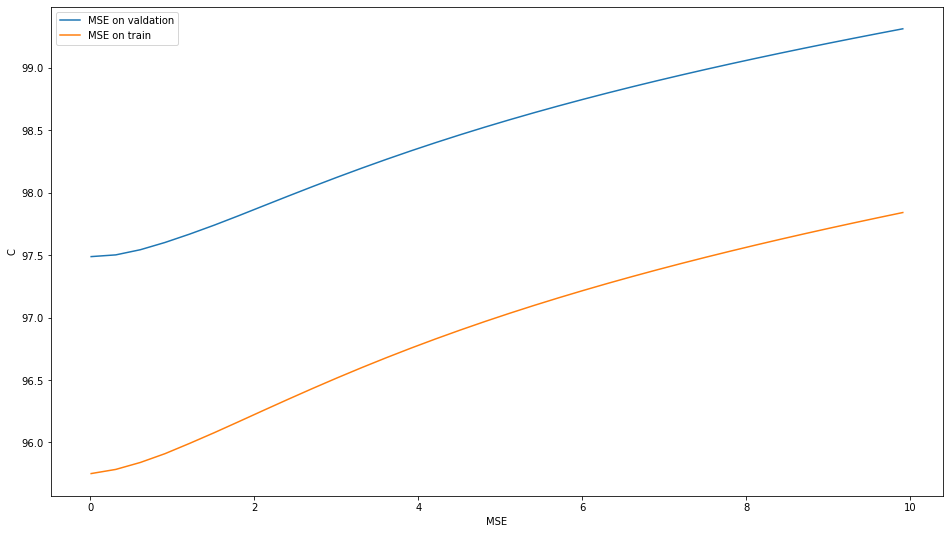

In [14]:
c_losses = []
train_losses = []
cs = np.arange(0.01, 10, 0.3)

for C in cs:
    scores, train_scores = get_cross_validation_score(LinearRegression, X, y, C=C, momentum=0.9)
    c_losses.append(scores.mean())
    train_losses.append(train_scores.mean())
    
plt.figure(figsize=(16, 9))

plt.plot(cs, c_losses, label="MSE on valdation")
plt.xlabel("MSE") 
plt.ylabel("C")

plt.plot(cs, train_losses, label="MSE on train")
plt.xlabel("MSE") 
plt.ylabel("C")

plt.legend()
plt.show()

In [19]:
import random

class RandomSearchCrossValidation:
    def __init__(self, trials_number, params_bound, splits_number=5):
        self.trials_number = trials_number
        self.params_bound = params_bound
        self.splits_number = splits_number
        
    def search(self, Regressor, X, y):
        scores = []
        for i in range(self.trials_number):
            params = {
                key: random.uniform(v[0], v[1]) for key, v in self.params_bound.items()
            }
            scores.append(
            {
                "params": params,
                "scores": get_cross_validation_score(Regressor, X, y, 
                                                     splits_number=self.splits_number, **params)[0].mean()
            })
        return scores

In [20]:
random_serach_cv = RandomSearchCrossValidation(100, {
    "learning_rate": (0.001, 0.00001),
    "C": (0.1, 10),
    "momentum": (0.5, 0.95)
})

results = random_serach_cv.search(LinearRegression, X, y)

sorted(results, key=lambda x: x["scores"])[0]

{'params': {'learning_rate': 0.0007781440528717295,
  'C': 2.0131027494696907,
  'momentum': 0.848184420978152},
 'scores': 97.36304168701172}